<a href="https://colab.research.google.com/github/shimon166/Shutterfly/blob/master/sfly_homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
from itertools import chain
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
online_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/online.csv")
order_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/order.csv")

**Objective: Develop a predictive model based on the provided Order and Online customer behavior data (data.zip). The analysis can be done in R or Python and should be presented in an R-Studio Notebook or Jupyter Notebook. The assignment should produce a multi-class classification supervised learning model to predict product category (prodcat1) a customer is likely to order. Use your expertise to design the analysis and provide a rationale of chosen approach. Once completed, please upload your assigment to your personal github repo and share the link. In your workflow, please touch on each of the following areas:**
1. Exploration and understanding of the data sets
2. Feature engineering
3. Feature selection
4. Model design and sampling
5. Model generation
6. Model evaluation
7. Summary of results: 2-3 paragraphs textual summary


# Exploration and understanding of the data sets
To the best of my understanding the two datasets "orders" and "online" recorded over time.


1. We will find the overlapping dates between those datasets and use only the common range between them.
The results shows two years of ovaerlapping date range between 2016-01-01 00:00:08 to 2017-12-31 23:58:05.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
# Data Exploration

# Finding overlapping dates between the two datasets
print("Orders dataset dates range between "+str(order_df["orderdate"].min()) +" to "+ str(order_df["orderdate"].max()))
print("Online dataset dates range between "+str(online_df["dt"].min()) +" to "+ str(online_df["dt"].max()))

maximal_shared_date = min([order_df["orderdate"].max(),online_df["dt"].max()])
print("maximal shared date: " + str(maximal_shared_date))
#Use only the overlapping dates of those two datasets.
order_df = order_df.loc[order_df["orderdate"] < maximal_shared_date]
online_df = online_df.loc[online_df["dt"] < maximal_shared_date]

print("Orders new shape: " + str(order_df.shape))
print("Online new shape: " + str(online_df.shape))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Orders dataset dates range between 2016-01-01 05:05:14 to 2019-01-02 23:54:58
Online dataset dates range between 2016-01-01 00:00:08 to 2017-12-31 23:58:05
maximal shared date: 2017-12-31 23:58:05
Orders new shape: (176274, 6)
Online new shape: (954773, 7)


2. Simple check for missing values show that 'event1' in online.csv shows ~83% of missing values which makes this feature irrelevant.
'prodcat2' also has some missing values but this feature derived from 'prodcat1' what makes it irrelevant too.

In [ ]:
# Count empty cells and decide which to fill and which to drop from dataset.
print(order_df.shape)
print(order_df.isna().sum())
#print(order_df.describe())
print("--------------------------")
print(online_df.shape)
print(online_df.isna().sum())
#print(online_df.describe())

(176274, 6)
custno          0
ordno           0
orderdate       0
prodcat2     1823
prodcat1        0
revenue         0
dtype: int64
--------------------------
(954773, 7)
session          0
visitor          0
dt               0
custno           0
category         0
event1      789845
event2           0
dtype: int64


3. Check whether the class distribution need to be adjusted by over/under sampling. In addition, It will help us to decide which classifier to choose.


In [ ]:
#Check whether the class distribution need to be adjusted by over/under sampling. 
import plotly.express as px

fig = px.pie(order_df, values='ordno', names='prodcat1', title = "Classes distribution",hole=0.2)
fig.show()


4. I don't understand clearly what is the meaning of 'event2' in the online dataset, I guess this is a particular event that caused the user to browse the site.
Histograms shows that there are not clear difference of events between different categories.


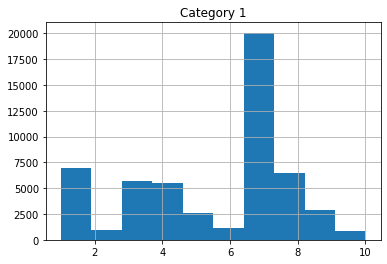

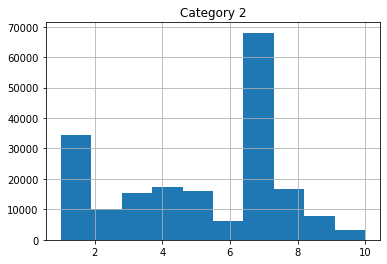

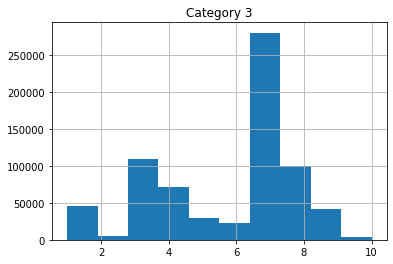

In [ ]:
#Actually I do not understand correctly what is the role for feature "event2" so lets check how each feature distributed
#over each category
grouped_df = online_df.loc[:,['category', 'event2']].groupby('category')
for key, item in grouped_df:
  ax = grouped_df.get_group(key).hist(column='event2')
  ax[0][0].set_title('Category '+str(key))

5. Plot the mean revenue for each user which can help us to classify if user is willing to buy products from expensive categories or not.

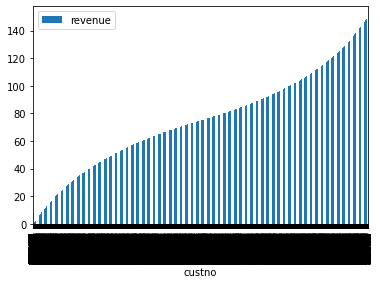

In [ ]:
#Mean revenue for each user bar plot
grouped_df = order_df.loc[:,['custno', 'revenue']].groupby('custno').mean()
grouped_df.sort_values(by=['revenue'],inplace=True)
#grouped_df.plot(kind='bar', title="revenue")
grouped_df.plot.bar(y='revenue')

# Feature engineering

Since the purpose of the task is to predict the product category that a user intends to acquire at a certain point of time, we would like to try to characterize the user's behavior in the period prior to acquisition in order to best predict their desires.
In order to study the history of each user we need to decide for a period of time that will be used to learn about the user, I decided to take a six month interval to study the behavior of each user.
This means the records to be used for learning will start from June 2017 rather than January.
For feature enfineering I wrote a function that extract features from date given.
Feature extracted as follows:
1. Calculate purchase probablity and count of each category made by the current user in between start_date and end_date.
2. Calculate online sessions probablity and count of each category made by the current user in between start_date and end_date.
3. Count number of times the user visit in the website in between start_date amd end_date.
4. Calculate the revenue of each category made by the current user in between start_date and end_date.
5. Count number of time the user visit in the website for each event2 between given dates.

In [ ]:
def get_statistics_between_dates(order_df,online_df,custid,end_date,start_date=None):
  if start_date is None:
    start_date = datetime(1970, 1, 1) 
  
  sub_df = order_df.loc[order_df['custno'] == custid]
  sub_df = sub_df.loc[sub_df['orderdate'].between(start_date,end_date, inclusive=False)]

  sub_online_df = online_df.loc[online_df['custno'] == custid]
  sub_online_df = sub_online_df.loc[sub_online_df['dt'].between(start_date,end_date, inclusive=False)]


  #Calculate purchase probablity and count of each category made by the current user in between start_date amd end_date
  purchase_prob_row = [0]*10
  purchase_count_row = [0]*10
  if not sub_df.empty:
    res_dict = sub_df.groupby("prodcat1").groups
    for cat,value in res_dict.items():
      purchase_prob_row[cat-1] = len(value)
      purchase_count_row[cat-1] = len(value)
    if np.sum(purchase_prob_row) != 0:  
      purchase_prob_row = purchase_prob_row/np.sum(purchase_prob_row)
  #print(purchase_prob_row)
  #Calculate online sessions probablity and count of each category made by the current user in between start_date amd end_date
  session_prob_row = [0]*10
  session_count_row = [0]*10
  if not sub_online_df.empty:
    res_dict = sub_online_df.groupby("category").groups
    for cat,value in res_dict.items():
      session_prob_row[cat-1] = len(value)
      session_count_row[cat-1] = len(value)
    if np.sum(session_prob_row) != 0:  
      session_prob_row = session_prob_row/np.sum(session_prob_row)
  #Count number of times the user visit in the website in between start_date amd end_date
  number_of_visits = [sub_online_df.shape[0]]

  #Calculate the revenue of each category made by the current user in between start_date amd end_date
  revenue_mean_row = [0]*10
  revenue_sum_row = [0]*10
  if not sub_df.empty:
    res_dict = sub_df.groupby("prodcat1").groups
    #print(res_dict)
    for cat,value in res_dict.items():
      revenue_mean_row[cat-1] = np.mean(sub_df.loc[np.asarray(value.values)]['revenue'])
      revenue_sum_row[cat-1] = np.sum(sub_df.loc[value.values]['revenue'])
  
  event2_count_row = [0]*10
  if not sub_online_df.empty:
    res_dict = sub_online_df.groupby("event2").groups
    for cat,value in res_dict.items():
      event2_count_row[cat-1] = len(value)
  
  return list(chain(purchase_prob_row,purchase_count_row,number_of_visits,session_prob_row,session_count_row,revenue_mean_row,revenue_sum_row,event2_count_row))
    



I chose 4 different periods for each observation in order locate long-term and short term behaviors.
The periods are: 6 months, 3 months, 1 month, and two weeks.

* I Decided to give extra columns for categories and events for later usage of new categories and events.
* Since this functions takes long time to calculate all those features, I saved its results and load them instead calculate all of theam each time
 

In [ ]:
from dateutil.relativedelta import relativedelta
import pandas as pd

order_df['orderdate'] = pd.to_datetime(order_df['orderdate'])
#There are 5 different categories on the dataset.
#I will allocate for 10 different categories for further usage.
print(order_df["prodcat1"].unique())

#Count number of different "event2" values for feature extraction phase.
#I will allocate for 10 different values for further usage.
print(online_df["event2"].unique())



online_df['dt'] =  pd.to_datetime(online_df['dt'])
online_df.sort_values(by=['dt'], inplace=True, ascending=True)
extend_list = []
min_date = order_df["orderdate"].min()
next_6_month_df = order_df.loc[order_df["orderdate"] > min_date + relativedelta(months=+6)]
next_6_month_df.sort_values(by=["orderdate"], inplace=True, ascending=True)
print(next_6_month_df.shape)
feature_extraction_df = pd.DataFrame()

load_features_from_file = True

if not load_features_from_file:
  weeks_arr = [24,12,4,2]
  for t in weeks_arr:
    i=0
    extend_list = []
    
    for index, row in next_6_month_df.iterrows():
      row = get_statistics_between_dates(order_df, online_df,row['custno'],row['orderdate'],row['orderdate'] - relativedelta(weeks=t))
      extend_list.append(row)
      i+=1
      if(i % 1000 == 0):
        print("iteration %d of %d in week %d" % (i,next_6_month_df.shape[0], t))
    cols = ["prod_online_prob_1","prod_online_prob_2","prod_online_prob_3","prod_online_prob_4","prod_online_prob_5","prod_online_prob_6","prod_online_prob_7","prod_online_prob_8","prod_online_prob_9","prod_online_prob_10",
                                                  "prod_online_count_1","prod_online_count_2","prod_online_count_3","prod_online_count_4","prod_online_count_5","prod_online_count_6","prod_online_count_7","prod_online_count_8","prod_online_count_9","prod_online_count_10",
                                                                                                "number_of_visits",
                                                  "session_prob_1","session_prob_2","session_prob_3","session_prob_4","session_prob_5","session_prob_6","session_prob_7","session_prob_8","session_prob_9","session_prob_10",
                                                  "session_count_1","session_count_2","session_count_3","session_count_4","session_count_5","session_count_6","session_count_7","session_count_8","session_count_9","session_count_10",

                                                  "revenue_mean_1","revenue_mean_2","revenue_mean_3","revenue_mean_4","revenue_mean_5","revenue_mean_6","revenue_mean_7","revenue_mean_8","revenue_mean_9","revenue_mean_10",
                                                  "revenue_sum_1","revenue_sum_2","revenue_sum_3","revenue_sum_4","revenue_sum_5","revenue_sum_6","revenue_sum_7","revenue_sum_8","revenue_sum_9","revenue_sum_10",
                                                  "event2_count_1","event2_count_2","event2_count_3","event2_count_4","event2_count_5","event2_count_6","event2_count_7","event2_count_8","event2_count_9","event2_count_10"]
    print("finished week %d" % t)
    extend_df = pd.DataFrame(extend_list,columns=[s +"_"+str(t) for s in cols])
    feature_extraction_df = pd.concat([feature_extraction_df, extend_df],axis=1)
  print(feature_extraction_df.shape)
  feature_extraction_df.to_csv("feature_extraction_df_1.csv")
else:
  feature_extracted_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/feature_extraction_df_1.csv")    


[1 7 3 2 4 5]
[ 1  2  3  4  5  6  7  8  9 10]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(133188, 6)


# Feature Selection
Since feature extraction phase produced 286 features its hard to debreif correlation matrix to detect correlated features.

To select relevant subset of features i will use some feature selection techniques:

1. Drop all low-variance features. 


In [ ]:
feature_extracted_df.reset_index(drop=True, inplace=True)
next_6_month_df.reset_index(drop=True, inplace=True)

X_df = pd.concat([feature_extracted_df,next_6_month_df[["custno","prodcat1"]]],axis=1)
X_df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
print(X_df.shape)
X_df.dropna(axis=0,inplace=True)
print(X_df.shape)

from sklearn.feature_selection import VarianceThreshold
thresh = .95
selector = VarianceThreshold(threshold=thresh)
#Fit the Model
selector.fit(X_df)
X_df = X_df.loc[:, selector.get_support()] #Array of all nonremoved features' names
print(X_df.shape)



(133188, 286)
(133188, 286)
(133188, 90)


2. Use sklearn feature selection techniques to select top 70 features. I chose to use tree based feature importance which is an inbuilt class that comes with Tree Based Classifiers, I will be using Extra Tree Classifier for extracting the top 70 features for the dataset.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



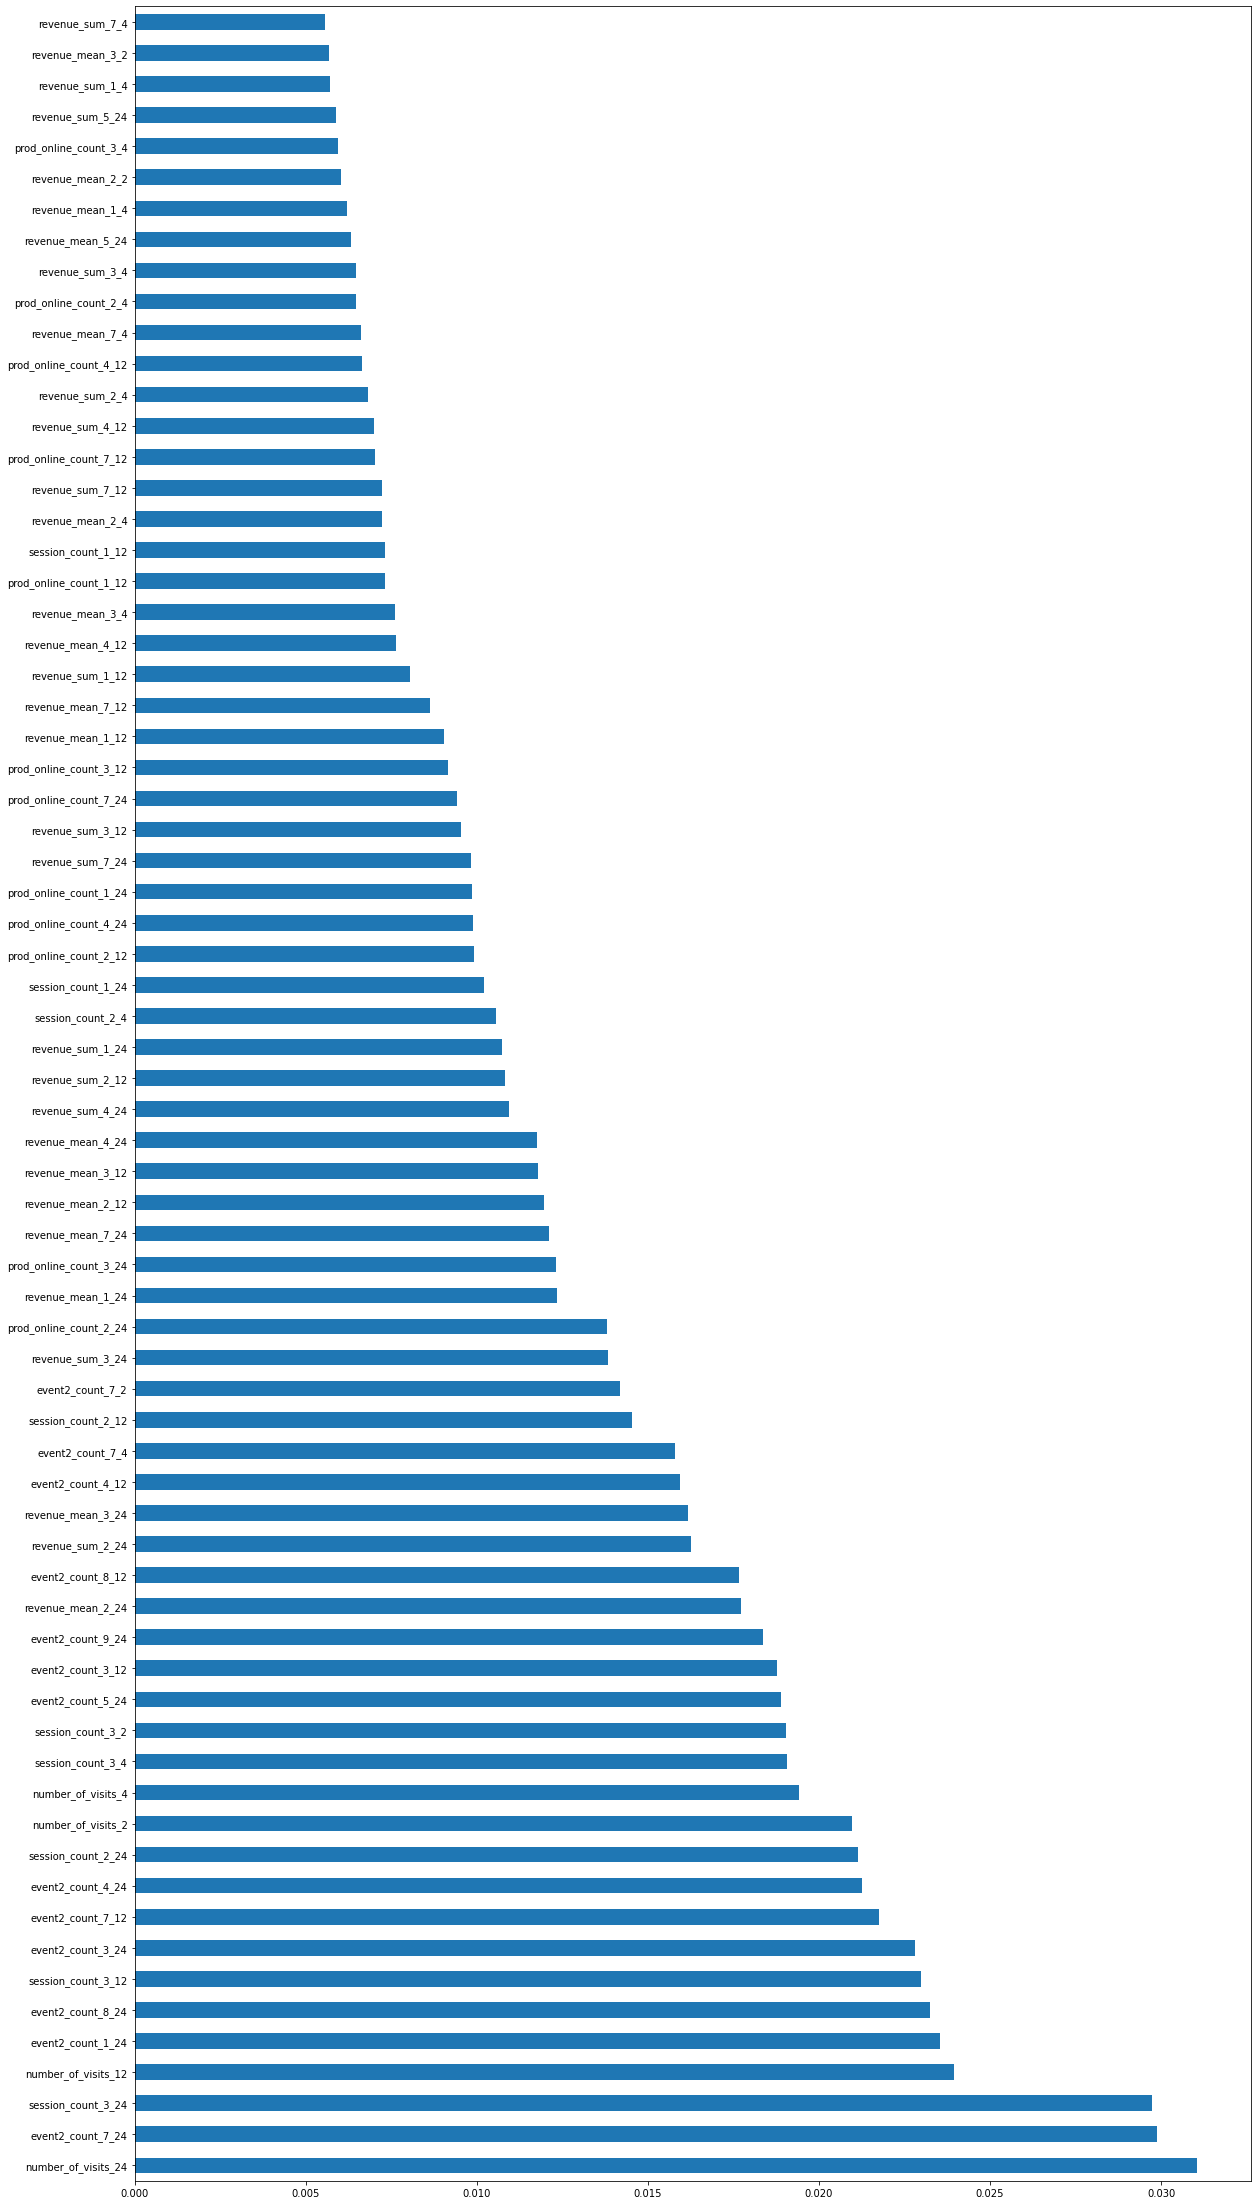

In [ ]:

X = X_df.drop(columns=['custno'],axis=1) #independent columns
y = X_df[['prodcat1']]
X.drop(columns=['prodcat1'],inplace=True,axis=1)

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(70).plot(kind='barh',figsize=(12,30))


The conclusion from the feature selection process is that 'event2' and 'revenue' are the most influential features in deciding which category for purchase.

Surprisingly, the long-term statistics were more influential than the short-term ones.


Take top 70 features selected based on the tree based feature selection.

In [ ]:
print(X.shape)
X = X[feat_importances.nlargest(70).index]
print(X.shape)

(133188, 88)
(133188, 70)


# Model design and sampling

I Chose to split the data for 70 percent of train and 30 percent for testing.
Since the data is temporal, K fold cross validation is not relevant because the need to test the model on the latest data.


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import accuracy_score
from collections import Counter
# split data into train and test sets
seed = 42

train_idx = int(X.shape[0]*0.7)
X_train = X.values[:train_idx,:]
X_test = X.values[train_idx:,:]
y_train = y.values[:train_idx,:]
y_test = y.values[train_idx:,:]


values, counts = np.unique(y_train, return_counts=True)
train_count_df = pd.DataFrame({'count':counts, 'Class':values})
fig = px.pie(train_count_df, values='count', names='Class', title = "Trainset classes distribution",hole=0.2,width=400,height=400)
fig
fig.show()

values, counts = np.unique(y_test, return_counts=True)
test_count_df = pd.DataFrame({'count':counts, 'Class':values})
fig = px.pie(test_count_df, values='count', names='Class', title = "Testset classes distribution",hole=0.2,width=400,height=400)
fig.show()



As can be seen in the pie chart, all classes distributed similarly between the train and test set.

# Model generation

For this multi class prediction task i chose to use XGBoostClassifier which proved as a relevant in many data science competitions, probably because his good results for the relatively short run time and tuning.

Due to short time, I will not perform grid search for the parameters of the xgboost algorithm and therefore the relevant code is in comment.

In [ ]:


#To ignore GridSearchCV from doing cross validation, specific fold need to be provided.
#The indices which have the value -1 will be kept in train.
train_indices = np.full((int(X_train.shape[0]*0.7),), -1, dtype=int)
# The indices which have zero or positive values, will be kept in test
test_indices = np.full((int(X_train.shape[0]*0.3),), 0, dtype=int)
test_fold = np.append(train_indices, test_indices)


ps = PredefinedSplit(test_fold)
print("Train set size: %d" % X_train.shape[0])
print("Test set size: %d" % X_test.shape[0])
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(n_estimators=100,
                    silent=True, nthread=1,max_depth = 50)
# grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='accuracy', n_jobs=4, verbose=3,cv=ps )
# grid.fit(X_train, y_train)
# print('\n All results:')
# print(grid.cv_results_)
# print('\n Best estimator:')
# print(grid.best_estimator_)
# print('\n Best score:')
# print(grid.best_score_ * 2 - 1)
# print('\n Best parameters:')
# print(grid.best_params_)
# results = pd.DataFrame(grid.cv_results_)
# results.to_csv('xgb-grid-search-results-01.csv', index=False)

xgb.fit(X_train, y_train)


Train set size: 93231
Test set size: 39957


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

# Model evaluation

The model results are not good at all, even in comparison to random selection.
We can see that the model predict for category 2 for most of the instances.

Test set accuracy: 0.36191405761193285


Text(0.5, 1.0, 'Normalized Confusion Matrix')

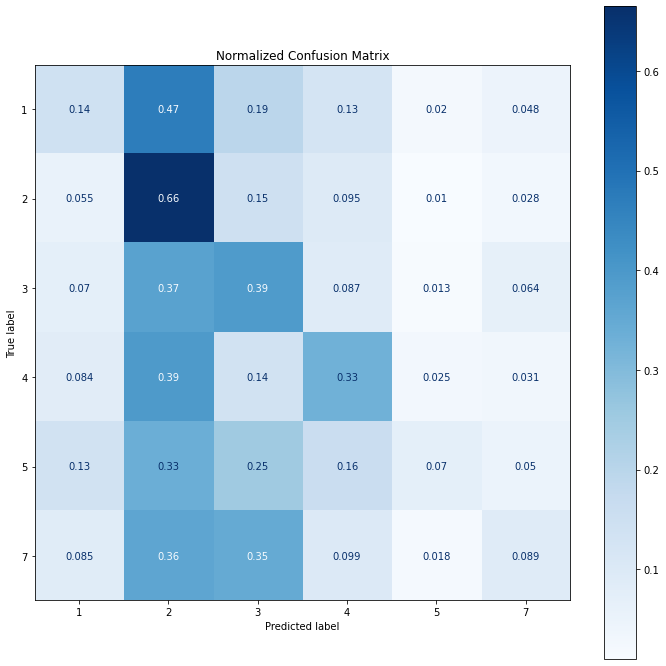

In [ ]:
from sklearn.metrics import plot_confusion_matrix
pred = xgb.predict(X_test)
print("Test set accuracy: " + str(accuracy_score(y_test,pred)))
fig, ax = plt.subplots(figsize=(12, 12))
disp = plot_confusion_matrix(xgb, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',ax=ax)
disp.ax_.set_title("Normalized Confusion Matrix")


# Summary of results

The task is to predict a category that the user is going to acquire at a given time.

There are a number of possible ways to address this kind of problem. The first way is to characterize each user's preferences, Within the data and the time received this can be a problematic because it requires a lot of information to model each user. In addition, It requires also to model a generic user to handle cold start (new users without any history).
Another way (my choise) is to extract time frame features of pre-defined time windows, This way does not handle user specific preferences.

In the short amount of time I decided to extract as many features as possible from a number of different time windows that represent the long-term and short-term behavior of the same user. Then, select the best features using feature-selection techniques and perform parameter tuning on a selected model to get the best accuracy.

In practice, the results showed poor performance on the resulting data. Many future changes are emerging from the process to improve model prediction capabilities, I'll list some of them:

* Feature selection showed that 'event2' and 'revenue' are the most informative and can be used to extract more features (i.e spending behaviour of users,orders count, events and revenue count without category dependant).
* Feature selection also showed that long-term behaviour are more informative. Therefore, should consider remove all the short-term features.
* Add user categorization feature by considering several conditions.
* Make proper grid-search on different classification algorithms.
* Evaluate results with other metrics. (i.e ROC-AUC Curve)
